In [1]:
import pandas as pd
import numpy as np

import orbit
from orbit.models.ets import ETSMAP
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.utils.dataset import load_iclaims

In [2]:
orbit.__version__

'1.0.14dev'

In [3]:
%load_ext autoreload
%autoreload 2

## Data

In [4]:
raw_df = load_iclaims()

raw_df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [5]:
df = raw_df.copy()

In [6]:
df.head()

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


In [7]:
test_size=52

train_df=df[:-test_size]
test_df=df[-test_size:]

In [8]:
ets = ETSMAP(response_col='claims',
             date_col='week',
             seasonality=52,
             seed=2020)

In [9]:
ets.fit(train_df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_982090c5656030fa038b63e5c383dbff NOW.


In [10]:
predicted_df = ets.predict(df=df, decompose=True)

predicted_df

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95
0,2010-01-03,13.286278,13.386595,13.488893,12.950697,13.051014,13.153313,0.335581,0.335581,0.335581
1,2010-01-10,13.518043,13.617983,13.718010,12.952401,13.052341,13.152368,0.565642,0.565642,0.565642
2,2010-01-17,13.281869,13.382794,13.484381,12.954810,13.055735,13.157322,0.327059,0.327059,0.327059
3,2010-01-24,13.044363,13.146663,13.247726,12.951495,13.053795,13.154858,0.092868,0.092868,0.092868
4,2010-01-31,13.073034,13.172100,13.271784,12.959978,13.059043,13.158728,0.113056,0.113056,0.113056
...,...,...,...,...,...,...,...,...,...,...
438,2018-05-27,12.140860,12.329127,12.514468,12.239139,12.427405,12.612746,-0.098278,-0.098278,-0.098278
439,2018-06-03,12.079407,12.269740,12.459063,12.237072,12.427405,12.616729,-0.157665,-0.157665,-0.157665
440,2018-06-10,12.181612,12.368060,12.559936,12.240957,12.427405,12.619281,-0.059345,-0.059345,-0.059345
441,2018-06-17,12.149797,12.338719,12.529711,12.238484,12.427405,12.618398,-0.088687,-0.088687,-0.088687


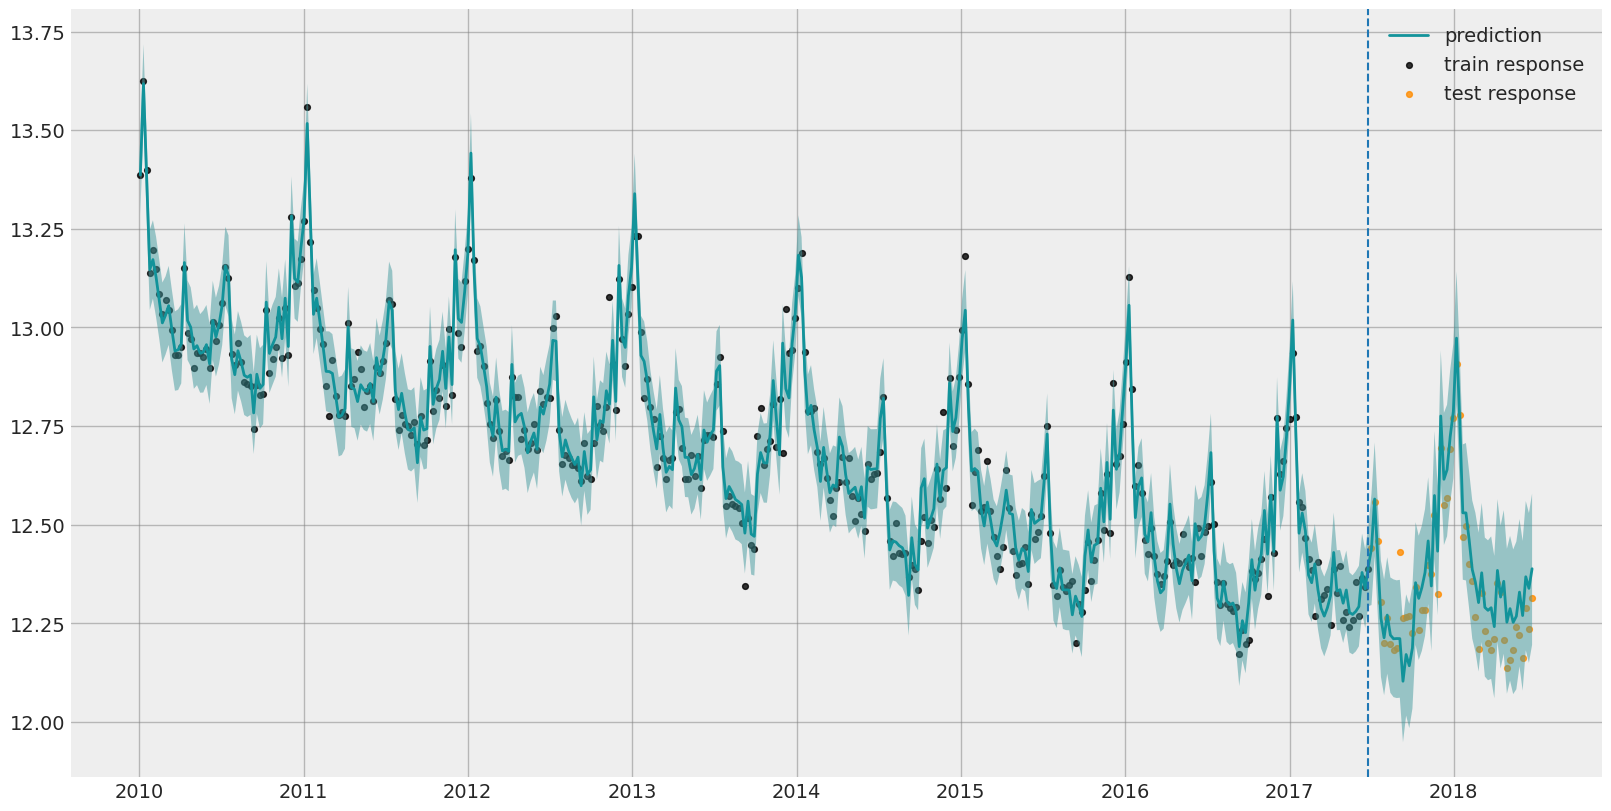

In [11]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col='week',
                        actual_col='claims',
                        test_actual_df=test_df)

/Users/zhishiw/Desktop/uTS-py/orbit/orbit/diagnostics/plot.py:218: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


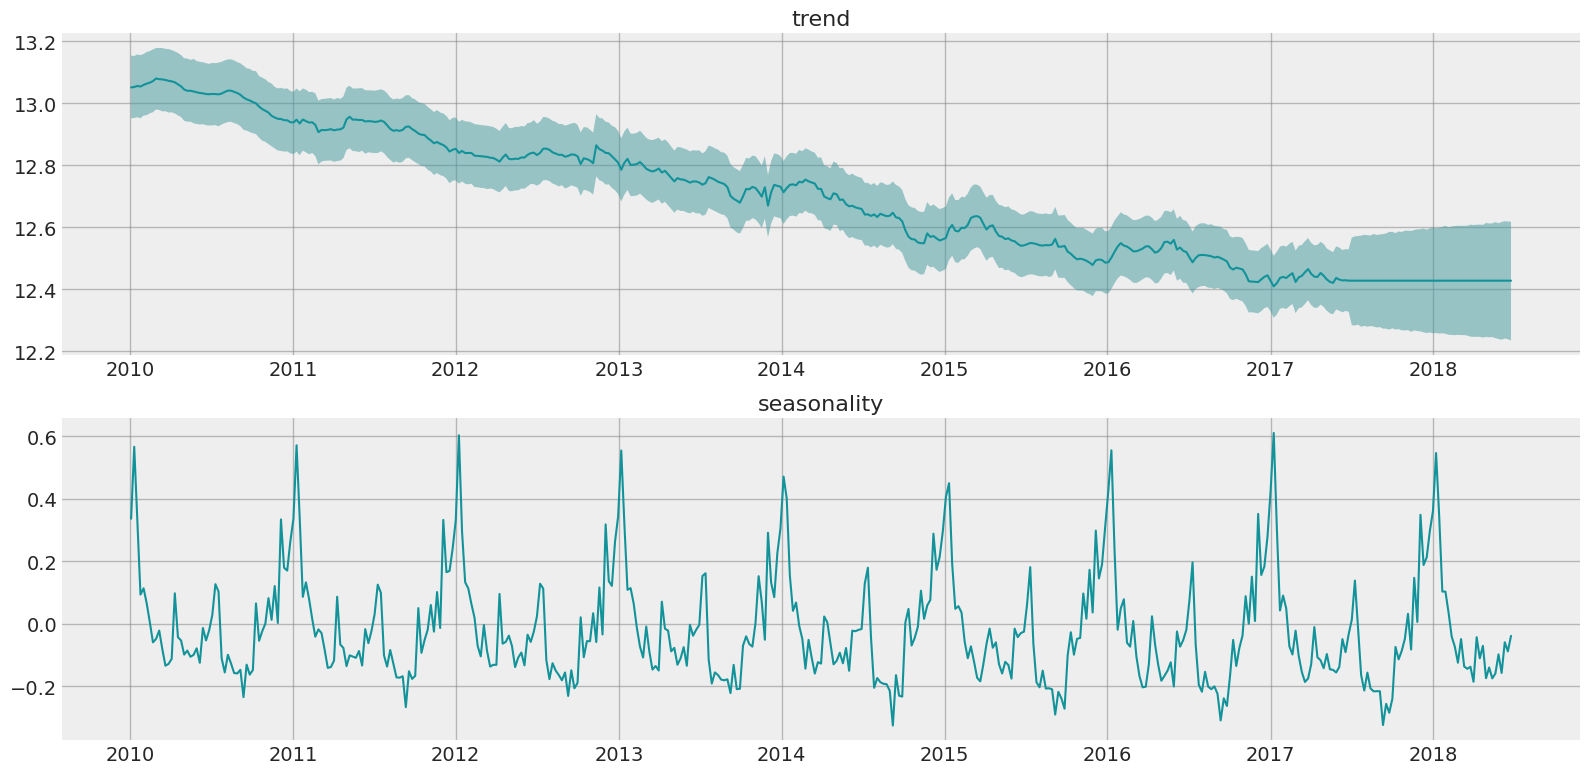

In [12]:
_ = plot_predicted_components(predicted_df=predicted_df, date_col='week')